# Privacy Preserving Machine Learning
---

In this notebook, we explore the use of homomorphic encryption with machine learning, specifically a multi layer perceptron (MLP). 

Libraries:
- TenSEAL by OpenMined 
- Concrete-ML by Zama. 

Dataset: 
- [Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset)

Attribution:
- The notebook is largely influenced by [Tenseal's tutorial](https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%201%20-%20Training%20and%20Evaluation%20of%20Logistic%20Regression%20on%20Encrypted%20Data.ipynb#)


Model architecture:
- Linear (64) 
- ReLU 
- Linear (2)  // 2 output class

In [1]:
import random
from time import time

import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas as pd
import tenseal as ts
import torch
import torch.nn as nn

from tqdm.auto import tqdm

from concrete.ml.torch.compile import compile_torch_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dataset preparation

In [3]:
df = pd.read_csv(".data/adult.csv")

In [4]:
class Dataset(torch.utils.data.Dataset):
      def __init__(self, df, train=True, scaler=None, one_hot_encoder=None):
          # Make a copy of the dataframe to avoid modifying the original
          cdf = df.copy()

          # Handle missing values
          cdf = cdf.replace('?', np.nan)

          # Fill missing values with the most common value for categorical features
          categorical_cols = ['workclass', 'occupation', 'native-country']
          for col in categorical_cols:
              cdf[col] = cdf[col].fillna(cdf[col].mode()[0])

          # Process target column first (before one-hot encoding)
          if train:
              cdf['income'] = cdf['income'].map({'>50K': 1, '<=50K': 0})
              target = cdf['income'].values
              cdf.drop('income', axis=1, inplace=True)
          else:
              # For test set
              if 'income' in cdf.columns:
                  cdf['income'] = cdf['income'].map({'>50K': 1, '<=50K': 0})
                  target = cdf['income'].values
                  cdf.drop('income', axis=1, inplace=True)
              else:
                  target = None

          # Extract numeric and categorical columns
          numeric_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
  'hours-per-week']
          cat_cols = [col for col in cdf.columns if col not in numeric_cols]

          # Normalize numeric columns
          if train:
              # If training data, fit a new scaler
              self.scaler = StandardScaler()
              cdf[numeric_cols] = self.scaler.fit_transform(cdf[numeric_cols])
          else:
              # If test data, use the provided scaler
              if scaler is not None:
                  cdf[numeric_cols] = scaler.transform(cdf[numeric_cols])

          # One-hot encode categorical features
          if train:
              # Save original categorical data for reference
              self.categorical_data = cdf[cat_cols].copy()
              # Apply one-hot encoding
              cdf_encoded = pd.get_dummies(cdf, columns=cat_cols)
              # Save column names for future reference
              self.encoded_columns = cdf_encoded.columns
              processed_data = cdf_encoded
          else:
              # For test data, ensure we have the same columns as training
              if one_hot_encoder is not None:
                  # One-hot encode the categorical columns
                  test_encoded = pd.get_dummies(cdf, columns=cat_cols)

                  # Add missing columns that are in training but not in test
                  for col in one_hot_encoder:
                      if col not in test_encoded.columns:
                          test_encoded[col] = 0

                  # Ensure columns are in the same order as training
                  processed_data = test_encoded[one_hot_encoder]

          # Convert to numpy array
          self.data = processed_data.values.astype('float32')
          self.target = target
          self.nfeatures = self.data.shape[1]
          self.train = train

      def __len__(self):
          return len(self.data)

      def __getitem__(self, idx):
          if self.target is not None:
              return self.data[idx], self.target[idx]
          else:
              return self.data[idx], np.nan

In [11]:
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 512

In [12]:
# Split the dataset into training and validation sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create training dataset first
train_dataset = Dataset(train_df, train=True)

# Create test dataset using the same scaler and one-hot encoding as training
test_dataset = Dataset(test_df, train=False,
                    scaler=train_dataset.scaler,
                    one_hot_encoder=train_dataset.encoded_columns)

# Create data loaders
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

# Verify shapes match (features should be same dimension)
print(f"Training data shape: {train_dataset.data.shape}")
print(f"Test data shape: {test_dataset.data.shape}")
print(f"Number of features: {train_dataset.nfeatures}")

Training data shape: (39073, 105)
Test data shape: (9769, 105)
Number of features: 105


In [13]:
next(iter(dataloader))

[tensor([[-0.5554, -0.8146, -0.0298,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.6105, -0.0519,  1.1367,  ...,  1.0000,  0.0000,  0.0000],
         [ 1.0477,  0.4777, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
         ...,
         [-1.4298, -0.6143, -1.9741,  ...,  1.0000,  0.0000,  0.0000],
         [-0.9926, -1.5955, -0.0298,  ...,  1.0000,  0.0000,  0.0000],
         [ 0.9019,  2.1408, -0.4187,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
         0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 

In [14]:
next(iter(dataloader))[0].shape

torch.Size([512, 105])

In [15]:
next(iter(testloader))[0].shape

torch.Size([64, 105])

In [16]:
len(testloader)

153

# Baseline (Vanilla Torch)

In [17]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(64, 2),
        )
        
    def forward(self, x):
        return self.model(x)

In [18]:
# no need for mps / cuda as its a very simple network
device = torch.device("cpu")

In [19]:
classifier = SimpleClassifier(train_dataset.nfeatures).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.00003)

In [20]:
train_losses = [] 
train_accuracy = []

epochs = 30

for epoch in tqdm(range(epochs)):
    running_correct = 0
    running_total = 0
    
    classifier.train()
    
    for i, (data, target) in (enumerate(dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = classifier(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1)
        running_correct += (pred == target).sum().item()
        running_total += target.size(0)
    
    print(f"epoch: {epoch+1}")
    print(f"  loss: {loss.item():.4f}")
    print(f"  accuracy: {(running_correct / running_total):.4f}")
    
    train_losses.append(loss.item())
    train_accuracy.append(running_correct / running_total)

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1
  loss: 0.6694
  accuracy: 0.5959
epoch: 2
  loss: 0.6467
  accuracy: 0.7600
epoch: 3
  loss: 0.6299
  accuracy: 0.7803
epoch: 4
  loss: 0.6097
  accuracy: 0.7786
epoch: 5
  loss: 0.5923
  accuracy: 0.7767
epoch: 6
  loss: 0.5422
  accuracy: 0.7774
epoch: 7
  loss: 0.5006
  accuracy: 0.7794
epoch: 8
  loss: 0.5442
  accuracy: 0.7829
epoch: 9
  loss: 0.4903
  accuracy: 0.7877
epoch: 10
  loss: 0.4957
  accuracy: 0.7941
epoch: 11
  loss: 0.4408
  accuracy: 0.7998
epoch: 12
  loss: 0.4209
  accuracy: 0.8064
epoch: 13
  loss: 0.4555
  accuracy: 0.8124
epoch: 14
  loss: 0.4384
  accuracy: 0.8174
epoch: 15
  loss: 0.4115
  accuracy: 0.8210
epoch: 16
  loss: 0.3919
  accuracy: 0.8235
epoch: 17
  loss: 0.4129
  accuracy: 0.8259
epoch: 18
  loss: 0.4058
  accuracy: 0.8279
epoch: 19
  loss: 0.3194
  accuracy: 0.8308
epoch: 20
  loss: 0.3697
  accuracy: 0.8325
epoch: 21
  loss: 0.4084
  accuracy: 0.8343
epoch: 22
  loss: 0.4110
  accuracy: 0.8356
epoch: 23
  loss: 0.3388
  accuracy: 0.83

In [21]:
%%time
# Get a test batch
data, target = next(iter(testloader))

# Run prediction with original PyTorch model
with torch.no_grad():
    original_output = classifier(data)  # Using the original PyTorch model
    original_pred = original_output.argmax(dim=1)
    original_accuracy = accuracy_score(target.numpy(), original_pred.numpy())

CPU times: user 2.28 ms, sys: 8.65 ms, total: 10.9 ms
Wall time: 2.36 ms


---

# 2. Concrete ML

### 2.1 Model Compilation

Compile the previously trained vanilla torch model into FHE-equivalent

In [20]:
# Create a representative input for compilation
torch_input = torch.randn(32, 105)

# Compile the PyTorch model
quantized_module = compile_torch_model(
    classifier.to('cpu'),  # Our trained model
    torch_input,           # Sample input for quantization and compilation
    n_bits=6,              # Bit precision for quantization
    rounding_threshold_bits={"n_bits": 6, "method": "approximate"}
)

quantized_module

### 2.2 Single inference 
Perform single inference using execute and simulate methods to see how long it takes and to verify the code works

In [26]:
%%time 

# EXECUTE a single inference

# Get a single test example
data, target = next(iter(testloader))
data = data[0].unsqueeze(0)
target = target[0]

# Original PyTorch model prediction (baseline)
with torch.no_grad():
    original_output = classifier(data)
    original_pred = original_output.argmax().item()

print(f"Original model prediction: {original_pred}")
print(f"Actual target: {target.item()}")

# Quantize the input
x_test_q = quantized_module.quantize_input(data.numpy())

# Run inference in simulate mode (simulates FHE behavior without encryption)
y_pred_simulate = quantized_module.quantized_forward(x_test_q, fhe="execute")

# Dequantize the output to get back to original scale
y_pred_dequantized = quantized_module.dequantize_output(y_pred_simulate)
simulate_pred = np.argmax(y_pred_dequantized)

print(f"\nSimulated FHE prediction: {simulate_pred}")
print(f"Prediction matches original: {original_pred == simulate_pred}")
print(f"Both match actual target: {original_pred == target.item() and simulate_pred == target.item()}")

# Show quantized and dequantized values to observe any precision loss
print(f"\nOriginal output: {original_output.detach().numpy()}")
print(f"Dequantized output: {y_pred_dequantized}")
print(f"Quantization impact (difference): {original_output.detach().numpy() - y_pred_dequantized}")

Original model prediction: 0
Actual target: 0

Simulated FHE prediction: 0
Prediction matches original: True
Both match actual target: True

Original output: [[ 1.5153463 -1.4379318]]
Dequantized output: [[ 1.54250049 -1.44298591]]
Quantization impact (difference): [[-0.0271542   0.00505413]]
CPU times: user 31.7 s, sys: 2.44 s, total: 34.2 s
Wall time: 6.12 s


In [27]:
%%time
# Simulate a single inference


# Get a single test sample (using only the first item in the batch)
rand_id = np.random.randint(1, TEST_BATCH_SIZE)

data, target = next(iter(testloader))
data_single = data[rand_id].unsqueeze(0)  # Take just the first sample and keep batch dimension
target_single = target[rand_id].item()    # Get the actual target value

# Quantize the input
x_test_q = quantized_module.quantize_input(data_single.numpy())

# Run inference in simulation mode
print("Running in FHE simulate mode...")
y_pred_simulate = quantized_module.quantized_forward(x_test_q, fhe="simulate")

# Dequantize the output
y_pred_dequantized = quantized_module.dequantize_output(y_pred_simulate)
simulate_pred = np.argmax(y_pred_dequantized)

print(f"\nFHE simulation prediction: {simulate_pred}")
print(f"Actual target: {target_single}")
print(f"Prediction matches target: {simulate_pred == target_single}")

# Show the output
print(f"\nFHE output (dequantized): {y_pred_dequantized}")

# Compare with original model prediction
with torch.no_grad():
    original_output = classifier(data_single)
    original_pred = original_output.argmax().item()
    
print(f"Original model prediction: {original_pred}")
print(f"Match between FHE simulation and original: {original_pred == simulate_pred}")

Running in FHE simulate mode...

FHE simulation prediction: 0
Actual target: 0
Prediction matches target: True

FHE output (dequantized): [[ 1.81829657 -1.70476236]]
Original model prediction: 0
Match between FHE simulation and original: True
CPU times: user 42.5 ms, sys: 131 ms, total: 173 ms
Wall time: 30 ms


### 2.3 Simulate a batch

In [ ]:
%%time

# Get a test batch
data, target = next(iter(testloader))

# Run prediction with original PyTorch model
with torch.no_grad():
    original_output = classifier(data)  # Using the original PyTorch model
    original_pred = original_output.argmax(dim=1)
    original_accuracy = accuracy_score(target.numpy(), original_pred.numpy())

# Quantize the input for FHE compatibility
x_test_q = quantized_module.quantize_input(data.numpy())

# Run the forward pass in simulated FHE mode
y_pred_fhe = quantized_module.quantized_forward(x_test_q, fhe="simulate")

# Dequantize the output back to floating point
y_pred_fhe_dequantized = quantized_module.dequantize_output(y_pred_fhe)

# Get class predictions
fhe_pred = torch.tensor(np.argmax(y_pred_fhe_dequantized, axis=1))

# Calculate batch accuracy
accuracy = accuracy_score(target.numpy(), fhe_pred.numpy())

# Display results
print(f"\nFHE Execution Results:")
print(f"Prediction: {fhe_pred}")
print(f"Actual target: {target}")
print(f"Batch accuracy: {accuracy:.4f} ({torch.sum(fhe_pred == target).item()}/{len(target)} correct)")

# Show the output (dequantized values)
# print(f"\nFHE output (dequantized):")
# print(f"{y_pred_fhe_dequantized}")

# Compare with the original model
print(f"\nOriginal Model Results:")
print(f"Original model predictions: {original_pred}")
print(f"Original model accuracy: {original_accuracy:.4f} ({torch.sum(original_pred == target).item()}/{len(target)} correct)")
print(f"Agreement between FHE and original model: {torch.sum(fhe_pred == original_pred).item()}/{len(fhe_pred)} samples")

# Results using the classifier (if different from model)
# print(f"\nClassifier Model Results:")
# with torch.no_grad():
#     classifier_output = classifier(data)
#     classifier_pred = classifier_output.argmax(dim=1)
#     classifier_accuracy = accuracy_score(target.numpy(), classifier_pred.numpy())
    
# print(f"Classifier predictions: {classifier_pred}")
# print(f"Classifier accuracy: {classifier_accuracy:.4f} ({torch.sum(classifier_pred == target).item()}/{len(target)} correct)")
# print(f"Agreement between FHE and classifier: {torch.sum(fhe_pred == classifier_pred).item()}/{len(fhe_pred)} samples")


FHE Execution Results:
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Actual target: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
Batch accuracy: 0.8516 (109/128 correct)

Original Model Results:
Original model pr

### 2.4 Execute a batch

In [29]:
%%time

# Get a test batch
data, target = next(iter(testloader))

# Run prediction with original PyTorch model
with torch.no_grad():
    original_output = classifier(data)  # Using the original PyTorch model
    original_pred = original_output.argmax(dim=1)
    original_accuracy = accuracy_score(target.numpy(), original_pred.numpy())

# Quantize the input for FHE compatibility
x_test_q = quantized_module.quantize_input(data.numpy())

# Run the forward pass in simulated FHE mode
y_pred_fhe = quantized_module.quantized_forward(x_test_q, fhe="execute")

# Dequantize the output back to floating point
y_pred_fhe_dequantized = quantized_module.dequantize_output(y_pred_fhe)

# Get class predictions
fhe_pred = torch.tensor(np.argmax(y_pred_fhe_dequantized, axis=1))

# Calculate batch accuracy
accuracy = accuracy_score(target.numpy(), fhe_pred.numpy())

# Display results
print(f"\nFHE Execution Results:")
print(f"Prediction: {fhe_pred}")
print(f"Actual target: {target}")
print(f"Batch accuracy: {accuracy:.4f} ({torch.sum(fhe_pred == target).item()}/{len(target)} correct)")

# Show the output (dequantized values)
# print(f"\nFHE output (dequantized):")
# print(f"{y_pred_fhe_dequantized}")

# Compare with the original model
print(f"\nOriginal Model Results:")
print(f"Original model predictions: {original_pred}")
print(f"Original model accuracy: {original_accuracy:.4f} ({torch.sum(original_pred == target).item()}/{len(target)} correct)")
print(f"Agreement between FHE and original model: {torch.sum(fhe_pred == original_pred).item()}/{len(fhe_pred)} samples")

# Results using the classifier (if different from model)
print(f"\nClassifier Model Results:")
with torch.no_grad():
    classifier_output = classifier(data)
    classifier_pred = classifier_output.argmax(dim=1)
    classifier_accuracy = accuracy_score(target.numpy(), classifier_pred.numpy())
    
print(f"Classifier predictions: {classifier_pred}")
print(f"Classifier accuracy: {classifier_accuracy:.4f} ({torch.sum(classifier_pred == target).item()}/{len(target)} correct)")
print(f"Agreement between FHE and classifier: {torch.sum(fhe_pred == classifier_pred).item()}/{len(fhe_pred)} samples")


FHE Execution Results:
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Actual target: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])
Batch accuracy: 0.8438 (108/128 correct)

Original Model Results:
Original model pr

---
# 3. Tenseal

In this section, we'll implement our classifier using TenSEAL for Homomorphic Encryption (HE). TenSEAL allows us to perform computations directly on encrypted data without decryption.

We'll follow these steps:
1. Initialize TenSEAL context with appropriate parameters
2. Create encrypted versions of our model
3. Perform inference on encrypted data
4. Compare performance and accuracy with plaintext model

The TenSEAL context determines how encryption works and what operations are possible. 
Key parameters include:

- **Polynomial Modulus Degree**: Controls the security level and the number of values that can be packed into a single ciphertext
- **Coefficient Modulus Bit Sizes**: Determines the computational depth (how many operations can be performed)
- **Global Scale**: Controls the precision of fractional values

Higher values generally mean more security and computational capability, but also larger ciphertexts and slower operations.

In [16]:
import tenseal as ts
import time

# Configure TenSEAL context with carefully chosen parameters
# Parameters are crucial for balancing security, precision, and performance

# Polynomial modulus degree - higher value allows more slots in a ciphertext
# but increases memory usage and computation time
poly_mod_degree = 8192  # Common choices: 4096, 8192, 16384, 32768

# Coefficient modulus bit sizes - controls computation depth
# First and last values are typically larger for encoding/decoding
# Middle values control each multiplication level
coeff_mod_bit_sizes = [40, 20, 20, 20, 40]  # Total of 140 bits for security level 128

# Create TenSEAL context
ts_context = ts.context(
    scheme=ts.SCHEME_TYPE.CKKS,  # CKKS scheme for approximate arithmetic
    poly_modulus_degree=poly_mod_degree,
    coeff_mod_bit_sizes=coeff_mod_bit_sizes
)

# Set global scale - controls precision of encrypted computations
# 2^20 provides good balance between precision and performance
ts_context.global_scale = 2**20

# Generate galois keys - needed for vector rotation operations
# during encrypted matrix multiplication
ts_context.generate_galois_keys()

print(f"TenSEAL context created with:")
print(f"  Polynomial modulus degree: {poly_mod_degree}")
print(f"  Coefficient modulus bits: {coeff_mod_bit_sizes} (total: {sum(coeff_mod_bit_sizes)})")
print(f"  Global scale: 2^{int(np.log2(ts_context.global_scale))}")

TenSEAL context created with:
  Polynomial modulus degree: 8192
  Coefficient modulus bits: [40, 20, 20, 20, 40] (total: 140)
  Global scale: 2^20


In [17]:
# poly_mod_degree = 16384
# coeff_mod_bit_sizes = [60, 40, 40, 60]
# # create TenSEALContext
# ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# # scale of ciphertext to use
# ctx_eval.global_scale = 2 ** 40
# # this key is needed for doing dot-product operations
# ctx_eval.generate_galois_keys()

In [18]:
ctx_eval = ts_context

### 3.1 Simple / sanity test with small matrix

In [26]:
# Testing 
a = torch.rand((1, 5))
b = torch.ones((5, 2))

a @ b

tensor([[1.9084, 1.9084]])

In [27]:
enc_a = ts.ckks_tensor(ctx_eval, a)
enc_b = ts.ckks_tensor(ctx_eval, b)

enc_a_at_enc_b = torch.tensor((enc_a @ enc_b).decrypt().tolist())
enc_a_at_enc_b

tensor([[1.9361, 1.9390]])

In [28]:
# Diff
enc_a_at_enc_b - a @ b

tensor([[0.0277, 0.0306]])

In [29]:
print(type(enc_a))
print(type(b))
torch.tensor((enc_a @ b).decrypt().tolist())

<class 'tenseal.tensors.ckkstensor.CKKSTensor'>
<class 'torch.Tensor'>


tensor([[1.9378, 1.9378]])

### 3.2 One layer forward pass


In [30]:
# get data from testloader and encrypt it
x, _ = next(iter(testloader))
enc_x = ts.ckks_tensor(ctx_eval, x.tolist())

# print
print(x)
print(x.shape)
print(type(enc_x))
print(type(classifier.model[0].weight.data))


tensor([[ 1.2663, -1.4850, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [-0.9926, -0.7285, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.3190, -0.1813,  1.1367,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.7740,  0.4755, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [-0.6283, -1.5178,  0.7479,  ...,  1.0000,  0.0000,  0.0000],
        [-1.1384, -0.5541, -0.4187,  ...,  1.0000,  0.0000,  0.0000]])
torch.Size([64, 105])
<class 'tenseal.tensors.ckkstensor.CKKSTensor'>
<class 'torch.Tensor'>


In [ ]:
# matmul of encrypted input * plain layer weights
enc_x @ (classifier.model[0].weight.data.cpu().T)

### 3.3 Simulate full forward pass

In [ ]:
w_ = classifier.model[0].weight.data.cpu().T
w_.to(torch.float8_e4m3fn)
xl = enc_x @ (classifier.model[0].weight.data.cpu().T)

In [ ]:
# Stuck at this point, scale out of bounds
w2_ = classifier.model[2].weight.data.cpu().T
w2_.to(torch.float8_e5m2)

xl @ (w2_)

### 3.4 Tenseal Encrypted Model

In [19]:
# Claude generated code
def minimax_relu_approximation(enc_x, domain=(-5, 5)):
    """
    Approximate ReLU using a minimax polynomial over specified domain.
    
    Minimax polynomials minimize the maximum error across the entire
    approximation range, providing better worst-case guarantees.
    
    Args:
        enc_x: Encrypted tensor/vector
        domain: Tuple indicating (min, max) range for approximation
        
    Returns:
        Encrypted tensor/vector with the ReLU approximation applied
    """
    # These coefficients are derived using the Remez algorithm or similar methods
    # for finding the minimax polynomial approximation for ReLU: f(x) = max(0, x)
    # over the domain [-5, 5]
    
    # Degree 3 minimax coefficients for ReLU over [-5, 5]
    # These minimize the maximum approximation error
    coeff = [0.16991, 0.5, 0.14192, -0.01687]
    
    # Calculate polynomial terms
    x_squared = enc_x * enc_x
    x_cubed = x_squared * enc_x
    
    # Build polynomial: a + bx + cx² + dx³
    # Note: We use regular operators as TenSEAL's CKKSTensor supports them
    result = coeff[1] * enc_x + coeff[2] * x_squared + coeff[3] * x_cubed + coeff[0]
    
    return result

In [20]:
# Code in this cell and after did not consider RELU yet, so need to adapt (hardcoded 2 layers)
class EncryptedClassifier:
    
    def __init__(self, unencrypted_model):
        
        # assuming same architecture
        self.w1 = unencrypted_model.model[0].weight.data.cpu() # [256, 15]
        self.b1 = unencrypted_model.model[0].bias.data.cpu()  # [256]
        
        self.w2 = unencrypted_model.model[2].weight.data.cpu()  # [2, 256]
        self.b2 = unencrypted_model.model[2].bias.data.cpu()  # [2]
 
 
    ## apparently, the context need to be adjusted so we can do matmul twice.
    ## it keeps making scale out of bounds error. To be researched
    def forward(self, enc_x):
        # assume encrypted input
        
        # enc_x would be in the shape of [1, 15]
        # while w1 is in shape [256, 15] 
        
        # first layer forward pass
        x = enc_x @ self.w1.T 
        
        # relu
        # x = minimax_relu_approximation(x)
        
        # second layer forward pass 
        x = x @ self.w2.T 
        
        return x        
        

    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        

    def encrypt(self, context):
        self.w1 = ts.ckks_vector(context, self.w1)
        self.b1 = ts.ckks_vector(context, self.b1)
        
        self.w2 = ts.ckks_vector(context, self.w2)
        self.b2 = ts.ckks_vector(context, self.b2)
        
    def decrypt(self, context):
        self.w1 = self.w1.decrypt()
        self.b1 = self.b1.decrypt()
        
        self.w2 = self.w2.decrypt()
        self.b2 = self.b2.decrypt()
        

encCls = EncryptedClassifier(classifier)

In [21]:
data, target = next(iter(testloader))

In [23]:
for i, (data, target) in enumerate((testloader)):
    print(f"Instance {i}")
    
    # Tenseal only supports lists iirc - need to double check
    # but as work around for now 
    for n in range(x.shape[0]):
        x = data[n]
        print(f"\t input tensor: {x}")
        
        enc_x = ts.ckks_tensor(ctx_eval, [x])
        print(f"\t ckks enc tensor: {enc_x}")
        
        # encrypted evaluation
        enc_out = encCls(enc_x)
        print(f"\t forward output tensor: {enc_out}")
        
        # plain comparison
        out = enc_out.decrypt()
        print(f"\t decrypted output: {torch.tensor(out.tolist())}")
    
        if n == 3:
            break

Instance 0


NameError: name 'x' is not defined

In [24]:
for i, (data, target) in enumerate((testloader)):
    print(f"Instance {i}")
    
    # Tenseal only supports lists iirc - need to double check
    # but as work around for now 
    x = data
    print(f"\t input tensor: {x}")
    
    enc_x = ts.ckks_tensor(ctx_eval, x)
    print(f"\t ckks enc tensor: {enc_x}")
    
    # encrypted evaluation
    enc_out = encCls(enc_x)
    print(f"\t forward output tensor: {enc_out}")
    
    # plain comparison
    out = enc_out.decrypt()
    print(f"\t decrypted output: {torch.tensor(out.tolist())}")

    if i == 3:
        break

Instance 0
	 input tensor: tensor([[ 1.2663, -1.4850, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [-0.9926, -0.7285, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.3190, -0.1813,  1.1367,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [-0.7740,  0.4755, -0.4187,  ...,  1.0000,  0.0000,  0.0000],
        [-0.6283, -1.5178,  0.7479,  ...,  1.0000,  0.0000,  0.0000],
        [-1.1384, -0.5541, -0.4187,  ...,  1.0000,  0.0000,  0.0000]])


KeyboardInterrupt: 

In [34]:
start_time = time.time()

total_samples = 0
torch_correct = 0
tenseal_correct = 0
agreement = 0

for i, (data, target) in enumerate(testloader):
    if i >= 1:
        break
        
    batch_size = data.shape[0]
    total_samples += batch_size
    
    # Original PyTorch model prediction
    with torch.no_grad():
        torch_output = classifier(data)
        torch_pred = torch_output.argmax(dim=1)
        torch_correct += (torch_pred == target).sum().item()
    
    # Encrypt the input
    enc_x = ts.ckks_tensor(ctx_eval, data.tolist())
    
    # TenSEAL model prediction
    enc_output = encCls(enc_x)
    
    # Decrypt and process the output
    decrypted_output = enc_output.decrypt()
    tenseal_pred = torch.tensor(decrypted_output.tolist()).argmax(dim=1)
    
    # Calculate metrics
    tenseal_correct += (tenseal_pred == target).sum().item()
    agreement += (tenseal_pred == torch_pred).sum().item()

# Calculate total execution time
execution_time = time.time() - start_time

# Compile results
results = {
    "total_samples": total_samples,
    "torch_accuracy": torch_correct / total_samples if total_samples > 0 else 0,
    "tenseal_accuracy": tenseal_correct / total_samples if total_samples > 0 else 0,
    "model_agreement": agreement / total_samples if total_samples > 0 else 0,
    "execution_time": execution_time,
    "time_per_sample": execution_time / total_samples if total_samples > 0 else 0
}

print("\n=== TenSEAL Evaluation Results ===")
print(f"Total samples: {total_samples}")
print(f"Original model accuracy: {results['torch_accuracy']:.4f}")
print(f"TenSEAL model accuracy: {results['tenseal_accuracy']:.4f}")
print(f"Model agreement: {results['model_agreement']:.4f}")
print(f"Total execution time: {results['execution_time']:.4f} seconds")
print(f"Average time per sample: {results['time_per_sample']:.4f} seconds")

results

: 

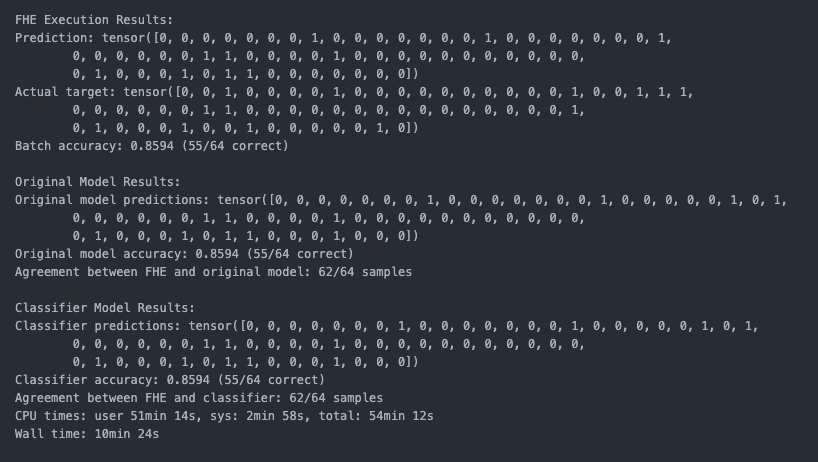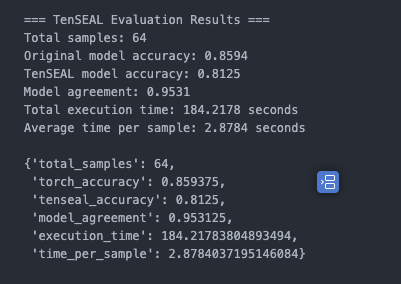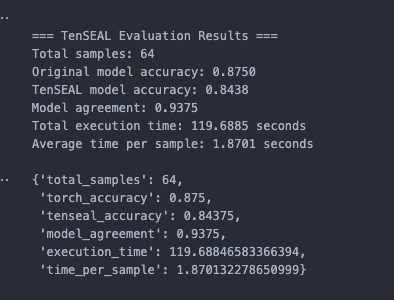